In [1]:
import torch
import numpy as np
import time
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import cv2
import random
import os
import matplotlib.pyplot as plt

In [8]:
# load model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /data/yylaiai/.cache/torch/hub/pytorch_vision_v0.10.0


In [87]:
transform_func = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [88]:
# img_data = torchvision.datasets.FakeData(size=1000, image_size=(3,224,224), transform=transform_func)
img_data = torchvision.datasets.Caltech101('./', transform=transform_func)

loader = DataLoader(img_data, batch_size=100)

In [89]:
dataset = next(iter(loader))[0].type(torch.FloatTensor)
dataset.shape

torch.Size([100, 3, 224, 224])

In [74]:
class GA_Torch_CPU:
    '''
    arguments e.g.:
    fit_func: [fitness_function, arguments:[]]
    fit_func: ["inc", ["theano"]]
    model: model
    dataset: x_test
    init_input_mut: 0.1
    init_weight_mut: 0
    r1 (crossover rate): 0.5
    r2 (mutation rate): 0.1
    m (number of parents): 5
    n (maximum dataset size allowed): 1000
    db_flag: 0
    '''
    def __init__(self, fit, model, dataset, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag):
        self.framework = "torch"

        self.fit_func = fit[0]
        self.fit_arg = fit[1]

        self.model = model.to('cpu')
        self.dataset = dataset.to('cpu')

        self.init_input_mut = init_input_mut
        self.init_weight_mut = init_weight_mut
        self.r1 = r1
        self.r2 = r2
        self.m = m
        self.n = n

        self.db_flag = db_flag
        self.redis_server = redis.Redis(db=self.db_flag)
        if not self.redis_server.ping():
            raise Exception("Redis server not set up")

        
        
    def initPopulation(self):
        # randomly choose n inputs from the dataset if n < len(dataset)
        if len(self.dataset) > self.n:
            selected_x = self.dataset[np.random.choice(len(self.dataset), size=self.n, replace=False)]
        else:
            selected_x = self.dataset
        
        self.mutated_inputs = selected_x
        
        cauchy_dist = torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0]))
#         cauchy_dist = torch.distributions.cauchy.Cauchy(torch.cuda.FloatTensor([0.0]), torch.cuda.FloatTensor([1.0]))
        
        # input level
        if self.init_input_mut != 0 and self.init_input_mut != None:
#             self.mutated_inputs = torch.clamp((self.mutated_inputs + torch.squeeze(cauchy_dist.sample(self.mutated_inputs.shape)) * self.init_input_mut),-1,1)
            self.mutated_inputs = self.mutated_inputs + torch.squeeze(cauchy_dist.sample(self.mutated_inputs.shape)) * self.init_input_mut


        # weight level
        if self.init_weight_mut != 0 and self.init_weight_mut != None:
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    param.add_(torch.squeeze(cauchy_dist.sample(param.size()), -1) * self.init_weight_mut)
                    
        
        return self.mutated_inputs

    def prepareFitness(self):
        if self.fit_func == "inc":
            backends = ["torch", self.fit_arg[0]]
            self.FFunc = InconsistencyFFunc(self.redis_server, self.db_flag, backends, self.model, self.mutated_inputs)
            self.FFunc.prepare()
        elif self.fit_func == "nan":
            backend = "torch"
            self.FFunc = NanFFunc(self.redis_server, self.db_flag, backend, self.model, self.mutated_inputs)
            self.FFunc.prepare()
        

    def computeFitness(self):
        if self.fit_func == "inc":
            self.fitness_values = torch.tensor(self.FFunc.compute(-1))

        elif self.fit_func == "nan":
            self.fitness_values = torch.tensor(self.FFunc.compute(-1))
            
        self.fitness_values = torch.squeeze(self.fitness_values)
        
        return self.fitness_values
        
    def getTopK_Fit(self, k):
        _, selected_index = torch.topk(self.fitness_values, self.m)
        return [self.mutated_inputs[selected_index], self.fitness_values[selected_index]]
        
    # select m candidates for parents of next-generation inputs
    def select(self):
        _, selected_index = torch.topk(self.fitness_values, self.m)
        self.selected_x = self.mutated_inputs[selected_index]
        return self.selected_x
    
    # select 2 parents from the candidates
    def selectParents(self):
        self.x1, self.x2 = random.sample(list(self.selected_x), 2)
        return self.x1, self.x2
    
    # return a flatten list of a crossover product of the selected parents
    def crossover(self):
        x1_flatten = self.x1.flatten()
        x2_flatten = self.x2.flatten()

        x1_factor = np.random.choice(2, size=x1_flatten.shape, p=[1-self.r1, self.r1])
        x2_factor = 1 - x1_factor
        
        self.x_prime = x1_flatten * x1_factor + x2_flatten * x2_factor

        return self.x_prime
    
    # mutate the crossover product and reshape it as the shape of the input instance
    def mutate(self):
        cauchy_dist = torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0]))
        
        input_shape = self.dataset[0].shape
        
#         self.x_2prime = torch.clamp((self.x_prime + torch.squeeze(cauchy_dist.sample(self.mutated_inputs.shape)).to('cpu') * self.r2),-1,1)
        self.x_2prime = self.x_prime + torch.squeeze(cauchy_dist.sample(self.x_prime.shape)) * self.r2

        self.x_2prime = self.x_2prime.reshape(input_shape)
        return self.x_2prime
    
    def update_inputs(self):
        self.redis_server.mset({"inputs": pickle.dumps(self.mutated_inputs.numpy())})
    
    # check if the new DNN model can predict the mutated inputs without triggering error
    def checkFailed(self):
        try:
            self.mutated_inputs = self.mutated_inputs.type(torch.FloatTensor)
            if self.fit_func == "inc":
                return []

            elif self.fit_func == "nan":
                predictions = self.model(self.mutated_inputs)
                if torch.isnan(predictions).any(): # if there is any nan in the predictions
                    return self.mutated_inputs
        except Exception as e:
            return [e]
            

In [75]:
import redis
import os
import numpy as np
import onnx
import onnx_tf
from onnx2keras import onnx_to_keras
import pickle
import tensorflow as tf
import torch
import keras
from multiprocessing import Process



def export_model(model_framework, model, model_name, dummy_input, onnx_path):
    if model_framework == "tensorflow":
        model.save(model_name)
        model_path = model_name
        os.system(f"python -m tf2onnx.convert --saved-model {model_path} --output {onnx_path}")
    elif model_framework == "torch":
        torch.onnx.export(model, dummy_input.to('cuda'), onnx_path)


def import_onnx(target_framework, onnx_path): # call this function after export_tf_model()
    onnx_model = onnx.load(onnx_path)  # load onnx model
    if target_framework == 'tensorflow':
        output_path = onnx_path[:-5]
        with tf.device('CPU'):
            tf_rep = onnx_tf.backend.prepare(onnx_model)  # prepare tf representation
            tf_rep.export_graph(output_path)  # export the model
    elif target_framework == 'theano':
        output_path = onnx_path[:-5] + '.h5'
        # Call the converter (input - is the main model input name, can be different for your model)
        k_model = onnx_to_keras(onnx_model, ['input'])
        k_model.save(output_path)
        
    
    return output_path

def load_model(model_framework, model_path):
    if model_framework == "tensorflow":
        with tf.device('CPU'):
            model = tf.keras.models.load_model(model_path)
    elif model_framework == "theano":
        model = keras.models.load_model(model_path)
       
    return model


def get_prediction_process(model_framework, db_flag, layer_idx):
    if model_framework == "theano":
        cmd = f"/data/yylaiai/anaconda3/envs/py36/bin/python get_prediction_{model_framework}.py {db_flag} {layer_idx}"
    else:
        cmd = f"/data/yylaiai/anaconda3/envs/fyp_v3/bin/python get_prediction_{model_framework}.py {db_flag} {layer_idx}"

    return Process(target=lambda: os.system(cmd))

def get_prediction_cmd(model_framework, db_flag, layer_idx):
    if model_framework == "theano":
        cmd = f"/data/yylaiai/anaconda3/envs/py36/bin/python get_prediction_{model_framework}.py {db_flag} {layer_idx}"
    else:
        cmd = f"/data/yylaiai/anaconda3/envs/fyp_v3/bin/python get_prediction_{model_framework}.py {db_flag} {layer_idx}"

    return cmd

class InconsistencyFFunc:
    def __init__(self, redis_server, db_flag, backends, model, inputs):
        self.redis_server = redis_server
        self.db_flag = db_flag
        self.backend_1, self.backend_2 = backends
        self.model_1 = model
        self.inputs = inputs

        self.model_1_name = 'model' + self.backend_1
        self.onnx_path = self.model_1_name + '.onnx'

    def prepare(self):
        # export model to onnx
        export_model(self.backend_1, self.model_1, self.model_1_name, self.inputs, self.onnx_path)

        # import onnx model to second DL framework
        self.model_2_path = import_onnx(self.backend_2, self.onnx_path)
        self.model_2 = load_model(self.backend_2, self.model_2_path)

        # store model and inputs
        if self.backend_1 == "torch":
            with self.redis_server.pipeline() as pipe:
                pipe.mset({f'model_{self.backend_1}': pickle.dumps(self.model_1.to('cpu'))})
                pipe.mset({f'model_{self.backend_2}': pickle.dumps(self.model_2)})
                pipe.mset({"inputs": pickle.dumps(self.inputs.cpu().numpy())}) # convert tensor to numpy before saving to redis
                pipe.execute()
        else:
            with self.redis_server.pipeline() as pipe:
                pipe.mset({f'model_{self.backend_1}': pickle.dumps(self.model_1)})
                pipe.mset({f'model_{self.backend_2}': pickle.dumps(self.model_2)})
                pipe.mset({"inputs": pickle.dumps(self.inputs)})
                pipe.execute()
    
    def compute(self):
        # run subprocess to get predictions
        p1 = get_prediction_process(self.backend_1, self.db_flag, layer_idx)
        p2 = get_prediction_process(self.backend_2, self.db_flag, layer_idx)
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        
        # load predictions
        with self.redis_server.pipeline() as pipe:
            pipe.hget("predictions", self.backend_1)
            pipe.hget("predictions", self.backend_2)
            predictions = pipe.execute()
        
        self.predictions_1 = pickle.loads(predictions[0])
        self.predictions_2 = pickle.loads(predictions[1])
        
        # compute fitness
        predictions_diff = np.abs(self.predictions_2 - self.predictions_1)
        
        self.fitness_values = np.sum(predictions_diff**2, axis=1) / len(self.predictions_1)
        
        
        return self.fitness_values

class NanFFunc:
    def __init__(self, redis_server, db_flag, backend, model, inputs):
        self.redis_server = redis_server
        self.db_flag = db_flag
        self.backend = backend
        self.model = model
        self.inputs = inputs


    def prepare(self):
        # store model and inputs
        if self.backend == "torch":
            with self.redis_server.pipeline() as pipe:
                pipe.mset({f'model_{self.backend}': pickle.dumps(self.model)})
                pipe.mset({"inputs": pickle.dumps(self.inputs.cpu().numpy())}) # convert tensor to numpy before saving to redis
                pipe.execute()
        else:
            with self.redis_server.pipeline() as pipe:
                pipe.mset({f'model_{self.backend}': pickle.dumps(self.model)})
                pipe.mset({"inputs": pickle.dumps(self.inputs)})
                pipe.execute()
            
    
    def compute(self, layer_idx):
        # run subprocess to get predictions
#         p = get_prediction_process(self.backend, self.db_flag, layer_idx)
#         p.start()
#         p.join()

        os.system(get_prediction_cmd(self.backend, self.db_flag, layer_idx))

        
        # load predictions
        self.predictions = pickle.loads(self.redis_server.hget("predictions", self.backend))

        # normalize neurons
        normalized_outputs = self.predictions#/(np.amax(self.predictions) - np.amin(self.predictions))
        
        # compute fitness
        self.fitness_values = np.amax(normalized_outputs, axis=1) - np.amin(normalized_outputs, axis=1)
        
        return self.fitness_values



## Testing

In [76]:
import os
import redis
import pickle
import subprocess

In [77]:
redis_server_path = '/data/yylaiai/redis/redis-stable/src/redis-server'
subprocess.Popen([redis_server_path])

<Popen: returncode: None args: ['/data/yylaiai/redis/redis-stable/src/redis-...>

27858:C 06 Jan 2022 20:38:31.259 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
27858:C 06 Jan 2022 20:38:31.260 # Redis version=6.2.6, bits=64, commit=00000000, modified=0, pid=27858, just started
27858:C 06 Jan 2022 20:38:31.260 # Warning: no config file specified, using the default config. In order to specify a config file use /data/yylaiai/redis/redis-stable/src/redis-server /path/to/redis.conf
27858:M 06 Jan 2022 20:38:31.262 # You requested maxclients of 10000 requiring at least 10032 max file descriptors.
27858:M 06 Jan 2022 20:38:31.262 # Server can't set maximum open files to 10032 because of OS error: Operation not permitted.
27858:M 06 Jan 2022 20:38:31.262 # Current maximum open files is 4096. maxclients has been reduced to 4064 to compensate for low ulimit. If you need higher maxclients increase 'ulimit -n'.
27858:M 06 Jan 2022 20:38:31.262 * monotonic clock: POSIX clock_gettime
27858:M 06 Jan 2022 20:38:31.262 # Warning: Could not create server TCP listening socket *:637

In [78]:
r = redis.Redis(db=1)

In [79]:
r.flushdb()

True

In [80]:
fit = ['nan', []]
model = model
dataset = dataset
init_input_mut = 0.01
init_weight_mut = 0
r1 = 0.5
r2 = 0.01
m = 5
n = 50
db_flag = 1

In [81]:
def ga_main(fit, model, dataset, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag, maxIter):
    F = []
    fits = []
    ga = GA_Torch_CPU(fit, model, dataset, init_input_mut, init_weight_mut, r1, r2, m, n, db_flag)
    ga.initPopulation()
    ga.prepareFitness()
    start_time = time.time()
    for i in range(maxIter):
        print("Running at iteration {}:".format(i+1))
        iter_start_time = time.time()
        ga.computeFitness()
        top_k_fitness = ga.getTopK_Fit(m)
        fits.append(top_k_fitness)
        P_prime = ga.select()
        test_cases = []
        test_cases.extend(P_prime)
        while len(test_cases) < ga.n:
            x1, x2 = ga.selectParents()
            x_prime = ga.crossover()
            r = random.uniform(0,1)
            if r < ga.r2:
                x_2prime = ga.mutate()
                test_cases.append(x_2prime)

        ga.mutated_inputs = torch.stack(test_cases,0)
        ga.update_inputs()
        X = ga.checkFailed()
        if X != None:
            F.extend(X)
        iter_end_time = time.time()
        
        print("top {} fitness scores: ".format(m), top_k_fitness[1])
        print("Taken time: {}".format(iter_end_time-iter_start_time))
        print()
    
    end_time = time.time()
    print("Total taken time: {}".format(end_time-start_time))
    
    if (i+10)%10 == 0:
        plt.plot((lambda L: [np.mean(i[1]) for i in L])(fits))

    return F, fits

In [82]:
fit_grad = lambda L: [torch.mean(i[1]) for i in L]

### Nan fitness testing

Running at iteration 1:
top 5 fitness scores:  tensor([33.5643, 27.6709, 24.0996, 23.8952, 19.0975])
Taken time: 56.03099274635315

Running at iteration 2:
top 5 fitness scores:  tensor([25.2191, 20.7453, 16.7981, 14.2483, 14.1313])
Taken time: 56.96797561645508

Running at iteration 3:
top 5 fitness scores:  tensor([30.9094, 16.3987, 12.8840, 12.2586, 11.3297])
Taken time: 55.83430337905884

Running at iteration 4:
top 5 fitness scores:  tensor([22.2632, 19.5612, 17.8092, 13.9477, 11.8218])
Taken time: 53.51255941390991

Running at iteration 5:
top 5 fitness scores:  tensor([16.5463, 16.0701, 14.8188, 13.5499, 13.1466])
Taken time: 47.51411843299866

Running at iteration 6:
top 5 fitness scores:  tensor([14.5506, 14.5291, 14.4148, 14.4024, 13.6237])
Taken time: 51.44824576377869

Running at iteration 7:
top 5 fitness scores:  tensor([14.5504, 14.0502, 14.0032, 14.0002, 13.7937])
Taken time: 45.08232760429382

Running at iteration 8:
top 5 fitness scores:  tensor([26.1304, 22.3033, 17.

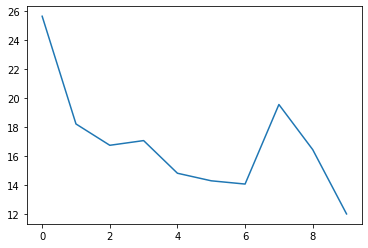

In [90]:
F, fits = ga_main(fit, model, dataset, init_input_mut, init_weight_mut, r1, r2, m, 100, db_flag, 10)
plt.plot(fit_grad(fits))
print(F)

Running at iteration 1:
top 5 fitness scores:  tensor([33.3959, 20.6875, 19.5636, 17.7924, 17.5124])
Taken time: 50.43898677825928

Running at iteration 2:
top 5 fitness scores:  tensor([25.0244, 16.3000, 16.0908, 14.5056, 13.8608])
Taken time: 57.706560373306274

Running at iteration 3:
top 5 fitness scores:  tensor([19.9286, 14.6819, 13.2744, 12.5003, 12.3322])
Taken time: 53.69862151145935

Running at iteration 4:
top 5 fitness scores:  tensor([11.6903, 11.2904, 11.2803, 11.2041, 11.0476])
Taken time: 55.25450038909912

Running at iteration 5:
top 5 fitness scores:  tensor([10.0481,  9.2115,  9.1827,  8.6406,  8.4418])
Taken time: 51.98711156845093

Running at iteration 6:
top 5 fitness scores:  tensor([20.2995, 17.7440, 16.5482, 15.4878, 13.5285])
Taken time: 52.93576788902283

Running at iteration 7:
top 5 fitness scores:  tensor([11.8300, 11.7629, 11.6206, 11.5911, 11.5481])
Taken time: 50.78547382354736

Running at iteration 8:
top 5 fitness scores:  tensor([9.9157, 9.7106, 9.67

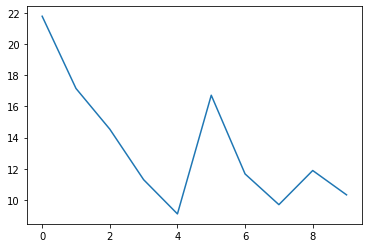

In [83]:
F, fits = ga_main(fit, model, dataset, init_input_mut, init_weight_mut, r1, r2, m, 100, db_flag, 10)
plt.plot(fit_grad(fits))
print(F)

### Validate the correctness of onnx run

In [32]:
import os
import onnx
import onnx_tf

In [29]:
model_tf = tf.keras.applications.resnet50.ResNet50()
model_tf.save('model_tf')

In [33]:
# export model to onnx
os.system(f"python -m tf2onnx.convert --saved-model model_tf --output model_tf.onnx")

/data/yylaiai/anaconda3/envs/fyp_v1/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-01-06 13:02:10,693 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-01-06 13:02:18,903 - INFO - Signatures found in model: [serving_default].
2022-01-06 13:02:18,903 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-01-06 13:02:18,905 - INFO - Output names: ['predictions']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-06 13:02:24,265 - WARNING - From /data/yylaiai/anaconda3/envs/fyp_v1/lib/python3.9/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.e

0

In [39]:
onnx_model = onnx.load('model_tf.onnx')
tf_rep = onnx_tf.backend.prepare(onnx_model)

In [48]:
# Predictions from onnx model
tf_rep.run(x_test_224[:100].astype(np.float32))[0]

array([[5.87748900e-06, 1.44407488e-04, 1.43289833e-06, ...,
        1.30673898e-05, 1.46243756e-05, 3.13351447e-05],
       [2.60217206e-07, 1.86157140e-05, 2.07693370e-06, ...,
        2.36852756e-07, 9.57605721e-07, 2.05558806e-07],
       [1.25319666e-05, 5.27493758e-05, 2.61272453e-06, ...,
        1.30566714e-05, 5.27439915e-05, 3.28969395e-06],
       ...,
       [1.09481385e-04, 1.26218496e-04, 2.46719865e-04, ...,
        1.48665304e-05, 2.12282059e-04, 2.50715326e-04],
       [2.27300575e-06, 2.45619503e-05, 1.03062723e-06, ...,
        1.17089307e-07, 4.74130547e-06, 1.47472846e-07],
       [5.36449897e-06, 1.25398628e-05, 4.52902032e-06, ...,
        5.96116195e-07, 1.85837926e-05, 1.42253953e-06]], dtype=float32)

In [47]:
# Predictions from original keras model
model_tf.predict(x_test_224[:100])

array([[5.87750128e-06, 1.44408405e-04, 1.43290140e-06, ...,
        1.30674553e-05, 1.46244211e-05, 3.13350647e-05],
       [2.60217178e-07, 1.86157813e-05, 2.07695120e-06, ...,
        2.36853396e-07, 9.57605494e-07, 2.05560340e-07],
       [1.25319430e-05, 5.27495795e-05, 2.61273431e-06, ...,
        1.30566841e-05, 5.27436423e-05, 3.28972578e-06],
       ...,
       [1.09480919e-04, 1.26217914e-04, 2.46719166e-04, ...,
        1.48665376e-05, 2.12281157e-04, 2.50715937e-04],
       [2.27299392e-06, 2.45618230e-05, 1.03061996e-06, ...,
        1.17088575e-07, 4.74127637e-06, 1.47471667e-07],
       [5.36452126e-06, 1.25399401e-05, 4.52906988e-06, ...,
        5.96125005e-07, 1.85840836e-05, 1.42255374e-06]], dtype=float32)

### Comparing results from onnx-tf model and pytorch model

In [92]:
# load model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# export torch model to onnx model
torch.onnx.export(model, dataset, 'resnet18.onnx')

Using cache found in /data/yylaiai/.cache/torch/hub/pytorch_vision_v0.10.0


In [93]:
onnx_model = onnx.load('resnet18.onnx')
tf_rep = onnx_tf.backend.prepare(onnx_model)

2022-01-06 21:03:26.867807: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-01-06 21:03:26.867920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ugcpu5
2022-01-06 21:03:26.867937: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ugcpu5
2022-01-06 21:03:26.868080: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-06 21:03:26.868189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-06 21:03:26.868207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-06 21:03:26.869126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

In [94]:
# Predictions from onnx model with tensorflow framework
tf_p = tf_rep.run(dataset.numpy())[0]
tf_p

2022-01-06 21:03:39.267638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[ 2.3780732 , -0.51659006,  1.9087082 , ..., -1.1365998 ,
         2.4594085 ,  1.848294  ],
       [-2.7463188 ,  0.10963102, -0.05917203, ..., -4.711442  ,
        -1.3287668 ,  2.734512  ],
       [ 7.179214  , -0.3559491 ,  1.1968242 , ...,  3.5934122 ,
         3.804097  , -1.9294106 ],
       ...,
       [ 3.6938746 ,  0.26586753,  2.7453773 , ...,  0.81940216,
         2.6023164 ,  2.3077004 ],
       [ 1.6574767 , -0.70285517,  0.18333775, ..., -0.13651896,
         2.323092  ,  4.7655525 ],
       [-0.06873637, -0.06405656,  1.4623221 , ..., -1.7709255 ,
         1.1293014 ,  2.1824486 ]], dtype=float32)

In [95]:
# Predictions from original pytorch model
torch_p = model(dataset)
torch_p.detach().numpy()

array([[ 0.36748672, -0.24576497,  1.077612  , ..., -1.3097494 ,
         0.24092245,  0.24740127],
       [-2.2053335 ,  1.1937183 , -1.7171804 , ..., -4.219491  ,
         1.3493766 ,  1.6978506 ],
       [ 3.6377506 , -1.0120234 , -1.264333  , ...,  1.0870712 ,
         2.485309  , -1.2884173 ],
       ...,
       [-1.085905  ,  0.5861136 ,  0.7961475 , ..., -1.7448101 ,
        -0.53566414, -0.1074152 ],
       [-0.6161134 , -3.0822282 ,  0.47919106, ..., -1.5526303 ,
         0.37363994,  1.4942672 ],
       [-1.1715766 , -1.2087795 ,  2.4718966 , ..., -2.9932578 ,
         1.3102981 , -0.6611268 ]], dtype=float32)

### Comparing the top-k results

In [114]:
# top-k results from pytorch model
torch.topk(torch.tensor(tf_p), 5, 1)[1]

tensor([[740, 784, 798,  87, 419],
        [453, 624, 454, 481, 917],
        [  0, 838, 939, 929, 955],
        [861, 714, 917, 971, 610],
        [419, 740, 589, 813, 784],
        [453, 398, 624, 495, 611],
        [624, 424, 453, 740, 813],
        [608, 834, 474, 793, 813],
        [834, 499, 813, 785, 419],
        [480, 799, 904, 707, 766],
        [813, 457, 785, 740, 784],
        [453, 648, 495, 496, 624],
        [499, 419, 785, 939, 617],
        [799, 834, 499, 904, 457],
        [955, 843, 838, 929, 904],
        [843, 904, 838, 929,   0],
        [740, 784, 587, 499, 731],
        [785, 834, 620,   0, 851],
        [419, 617, 813, 499, 740],
        [453, 624, 454, 481, 419],
        [929, 838,   0, 772, 419],
        [648, 453, 617, 495, 424],
        [617, 834, 543, 432, 419],
        [617, 838, 454, 415, 624],
        [617, 424, 419, 589, 585],
        [617, 713, 793, 589, 861],
        [617, 419, 834, 457, 905],
        [617, 453, 813, 419, 457],
        [453, 624, 4

In [113]:
# top-k results from onnx-tf model
torch.topk(torch.tensor(torch_p), 5, 1)[1]

/tmp/ipykernel_20970/1464738197.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.topk(torch.tensor(torch_p), 5, 1)[1]


tensor([[587, 758, 696, 593, 764],
        [477, 453, 784, 917, 587],
        [837, 843, 836, 237, 240],
        [758, 695, 455, 902, 783],
        [674, 313, 523, 722, 305],
        [374, 448, 865,  17, 726],
        [618, 587, 877, 666, 899],
        [583, 234, 539, 894, 739],
        [758, 843, 731, 785, 882],
        [583, 234, 161, 164, 827],
        [ 33, 659, 961,  53, 390],
        [853, 398, 464, 227, 915],
        [407, 469, 609, 745, 756],
        [862, 462, 644, 722, 792],
        [191, 189, 188, 104, 158],
        [295, 339, 235, 355, 104],
        [229, 187, 854, 722, 105],
        [736, 785, 620, 764, 851],
        [413, 609, 764, 796, 743],
        [587, 758, 845, 784, 456],
        [929, 522, 429, 593, 902],
        [502, 788, 855, 116, 648],
        [543, 422, 733, 450, 430],
        [415, 860, 509, 582, 762],
        [124, 990,  86, 118, 733],
        [712, 899, 680, 666, 804],
        [733, 852, 805, 430, 890],
        [778, 617, 467, 600, 517],
        [480, 707, 8

### Comparing inconsistency fitness score of the same images and different images from different frameworks 

In [ ]:
normal_fits = []
diff_fits = []

for x, label in loader:
    dataset = x
    
    # compute inconsistency fitness with different inputs
    tf_p = tf_rep.run(dataset.to('cpu').numpy()[:50])[0]
    torch_p = model(dataset[50:])

    tf_prob = tf.nn.softmax(tf_p, 1)
    torch_prob = torch.nn.functional.softmax(torch_p, dim=1)

    predictions_diff = np.abs(torch_prob.detach().numpy()-tf_prob)
    fitness_values = np.sum(predictions_diff**2, axis=1) / len(torch_prob)

    diff_fits.append((torch.sum(torch.topk(torch.tensor(fitness_values), 5)[0])/5).item())
    
    
    # compute inconsistency fitness with the same inputs
    tf_p = tf_rep.run(dataset.to('cpu').numpy()[:50])[0]
    torch_p = model(dataset[:50])

    tf_prob = tf.nn.softmax(tf_p, 1)
    torch_prob = torch.nn.functional.softmax(torch_p, dim=1)

    predictions_diff = np.abs(torch_prob.detach().numpy()-tf_prob)
    fitness_values = np.sum(predictions_diff**2, axis=1) / len(torch_prob)

    normal_fits.append((torch.sum(torch.topk(torch.tensor(fitness_values), 5)[0])/5).item())


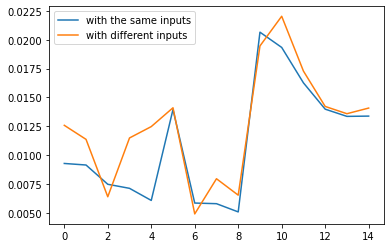

In [122]:
# plot lines
plt.plot(normal_fits, label = "with the same inputs")
plt.plot(diff_fits, label = "with different inputs")
plt.legend()
plt.show()